# Import Libraries

In [1]:
pip install mlxtend


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Utility Functions

In [4]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
        
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Load & Explore Data

In [5]:
# Load dataset
train_data = pd.read_csv('mitbih_train.csv')
test_data = pd.read_csv('mitbih_test.csv')

In [6]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 87553
Number of samples in test data: 21891


In [7]:
# Explore the dataset
train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [9]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


In [10]:
print(train_data.iloc[:, -1].value_counts())  # Check class distribution in train data

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [11]:
print(test_data.iloc[:, -1].value_counts())  # Check class distribution in test data

0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [12]:
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [13]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

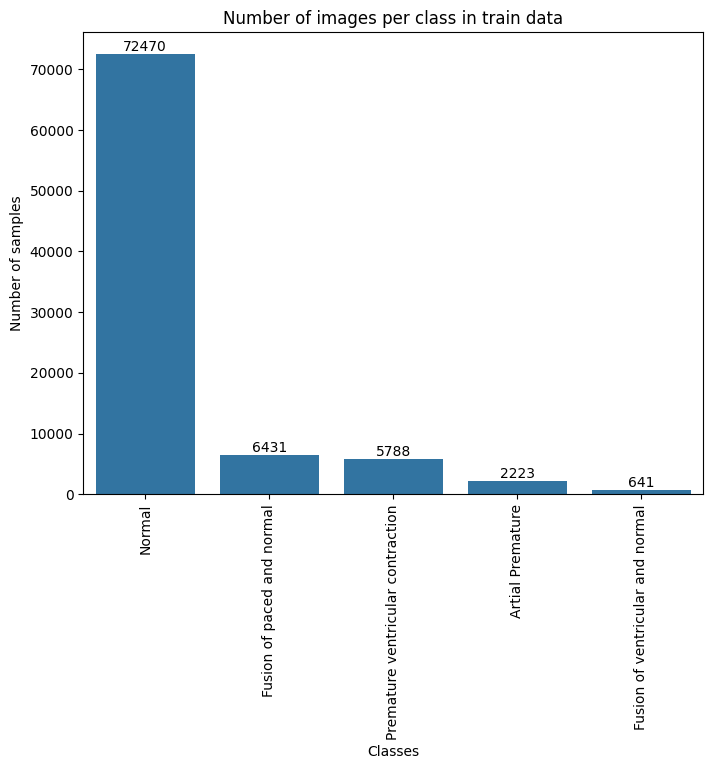

In [14]:
train_counts = train_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

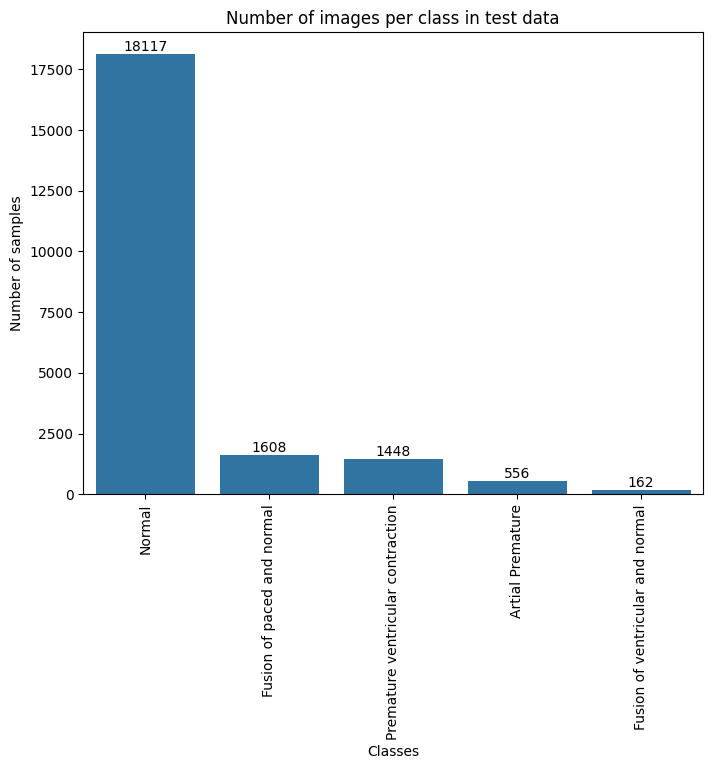

In [15]:
test_counts = test_data.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

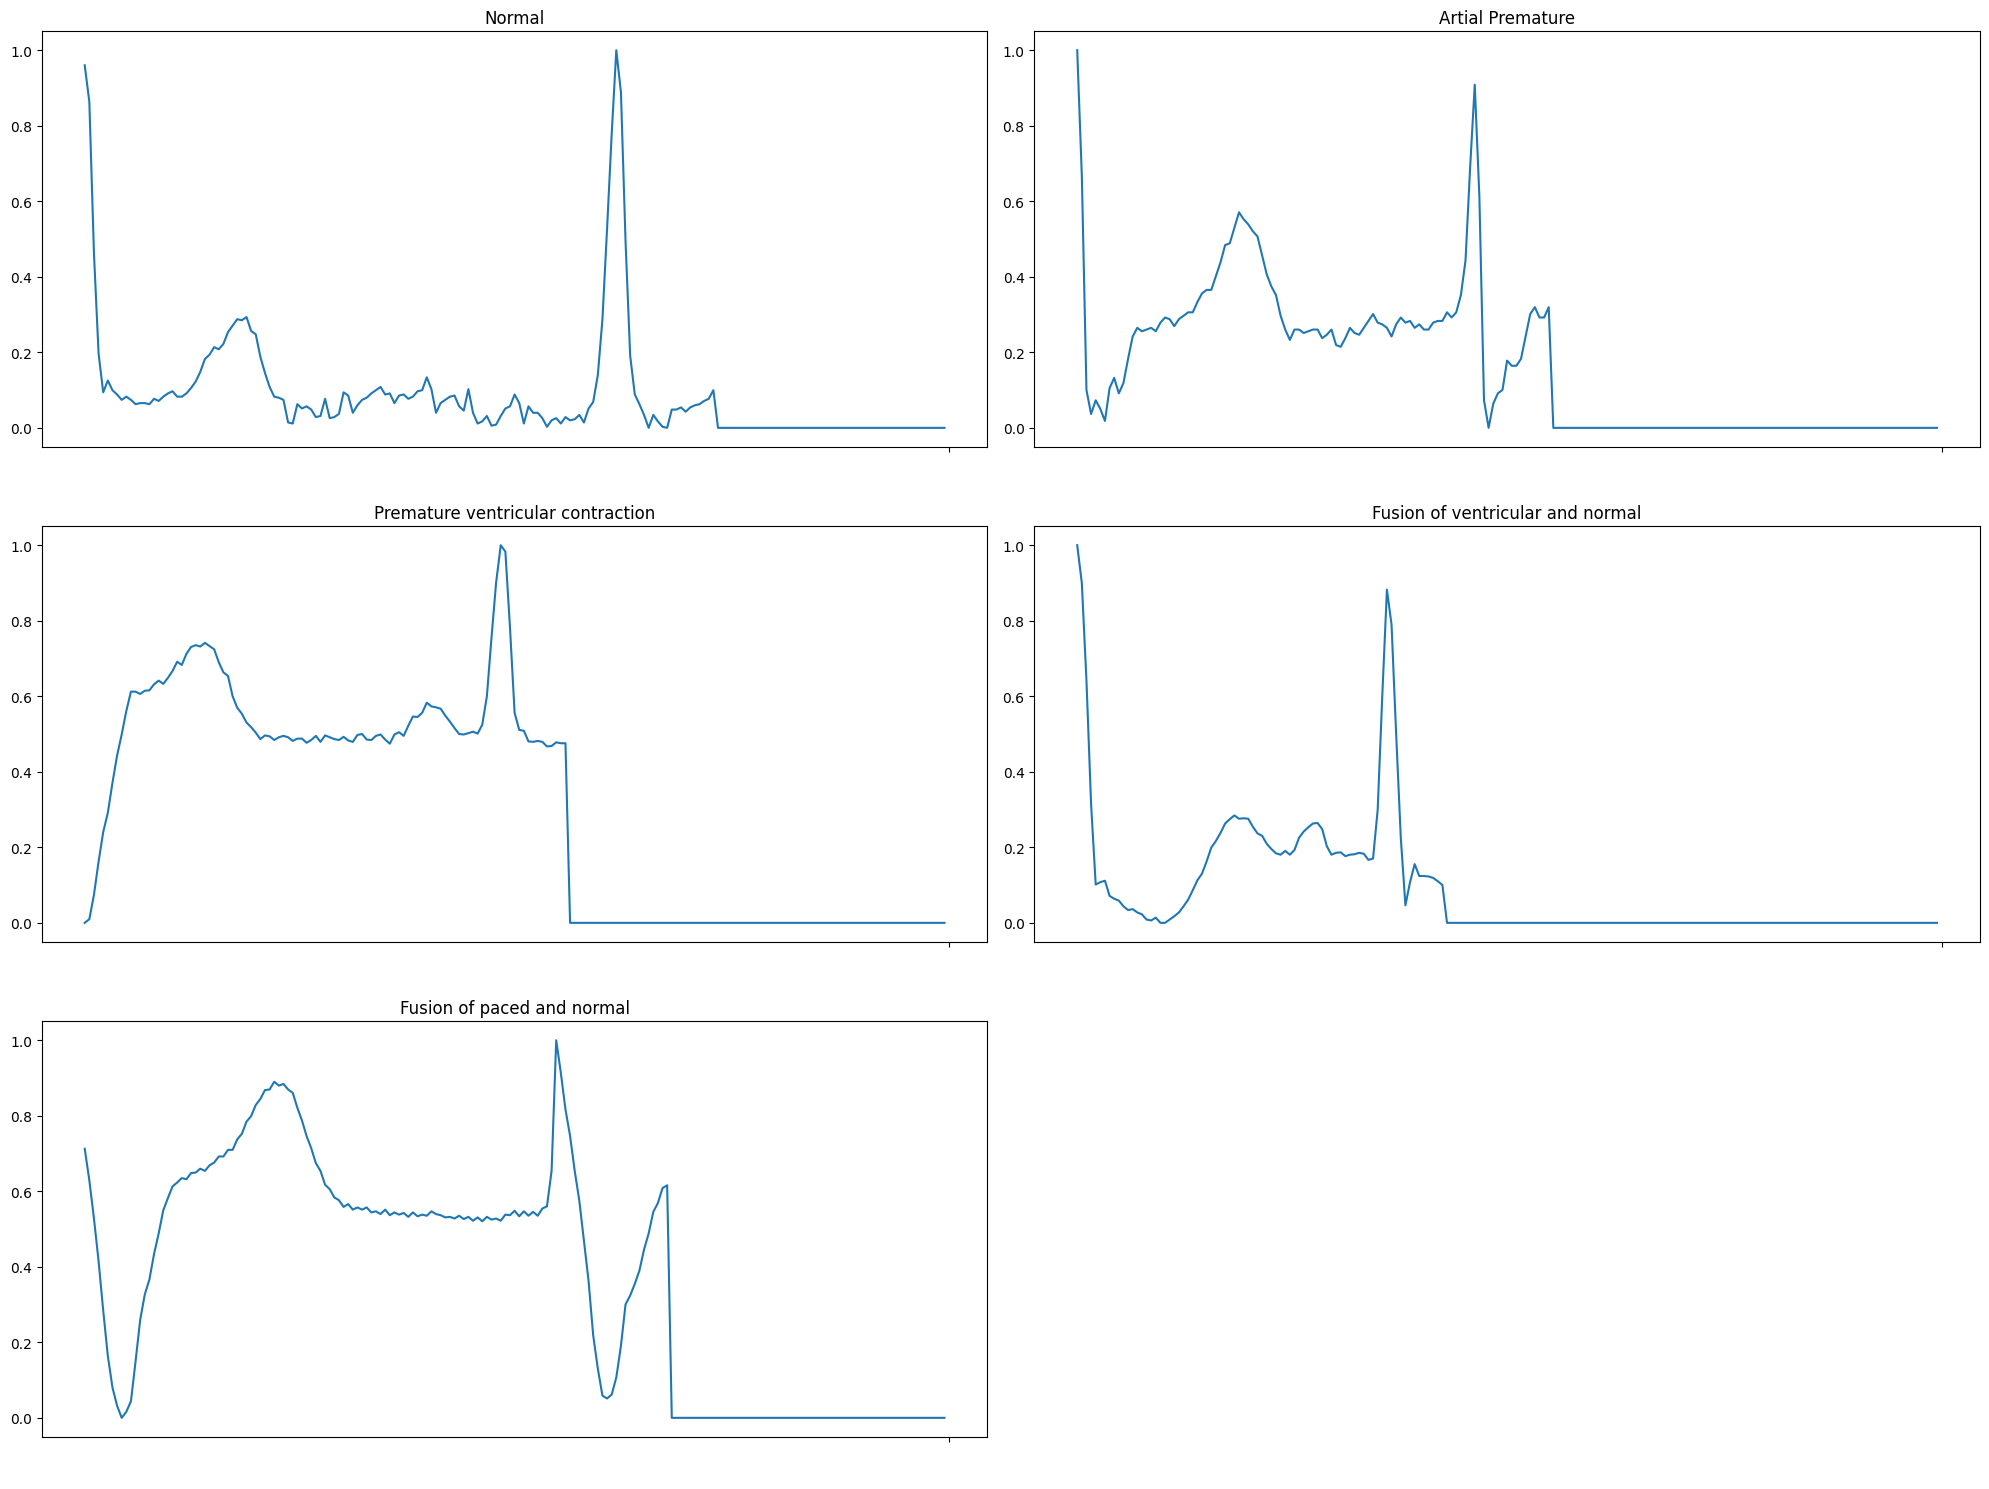

In [16]:
# Plot each class
train_classes = train_data.iloc[:, -1].unique()

plt.figure(figsize=(20, 15))

for i, cls in enumerate(train_classes):
    plt.subplot(3, 2, i + 1)
    plt.plot(train_data[train_data.iloc[:, -1] == cls].iloc[0, :-1])  # Exclude the label column
    plt.title(f'{list(labels.values())[i]}')
    plt.xlabel(" ")
    plt.xticks(ticks=" ",labels =" ",rotation=45)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))


print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_new.shape[0]}")

New Training set size: 87553
Validation set size: 10945
Test set size: 10946


In [18]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# GRU

In [19]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [20]:
gru_model = build_gru_model()

In [21]:
gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [22]:
gru_history = gru_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= callbacks)

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 497s 181ms/step - accuracy: 0.8444 - loss: 0.6083 - val_accuracy: 0.9352 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 475s 173ms/step - accuracy: 0.9398 - loss: 0.2194 - val_accuracy: 0.9555 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 484s 177ms/step - accuracy: 0.9597 - loss: 0.1506 - val_accuracy: 0.9649 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 466s 170ms/step - accuracy: 0.9673 - loss: 0.1208 - val_accuracy: 0.9711 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 492s 180ms/step - accuracy: 0.9710 - loss: 0.1086 - val_accuracy: 0.9741 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 473s 173ms/step - accuracy: 0.9752 - loss: 0.0930 - val_accuracy: 0.9754 - val_loss: 0.0928 - learning_rate: 0.0010
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 473s 173ms

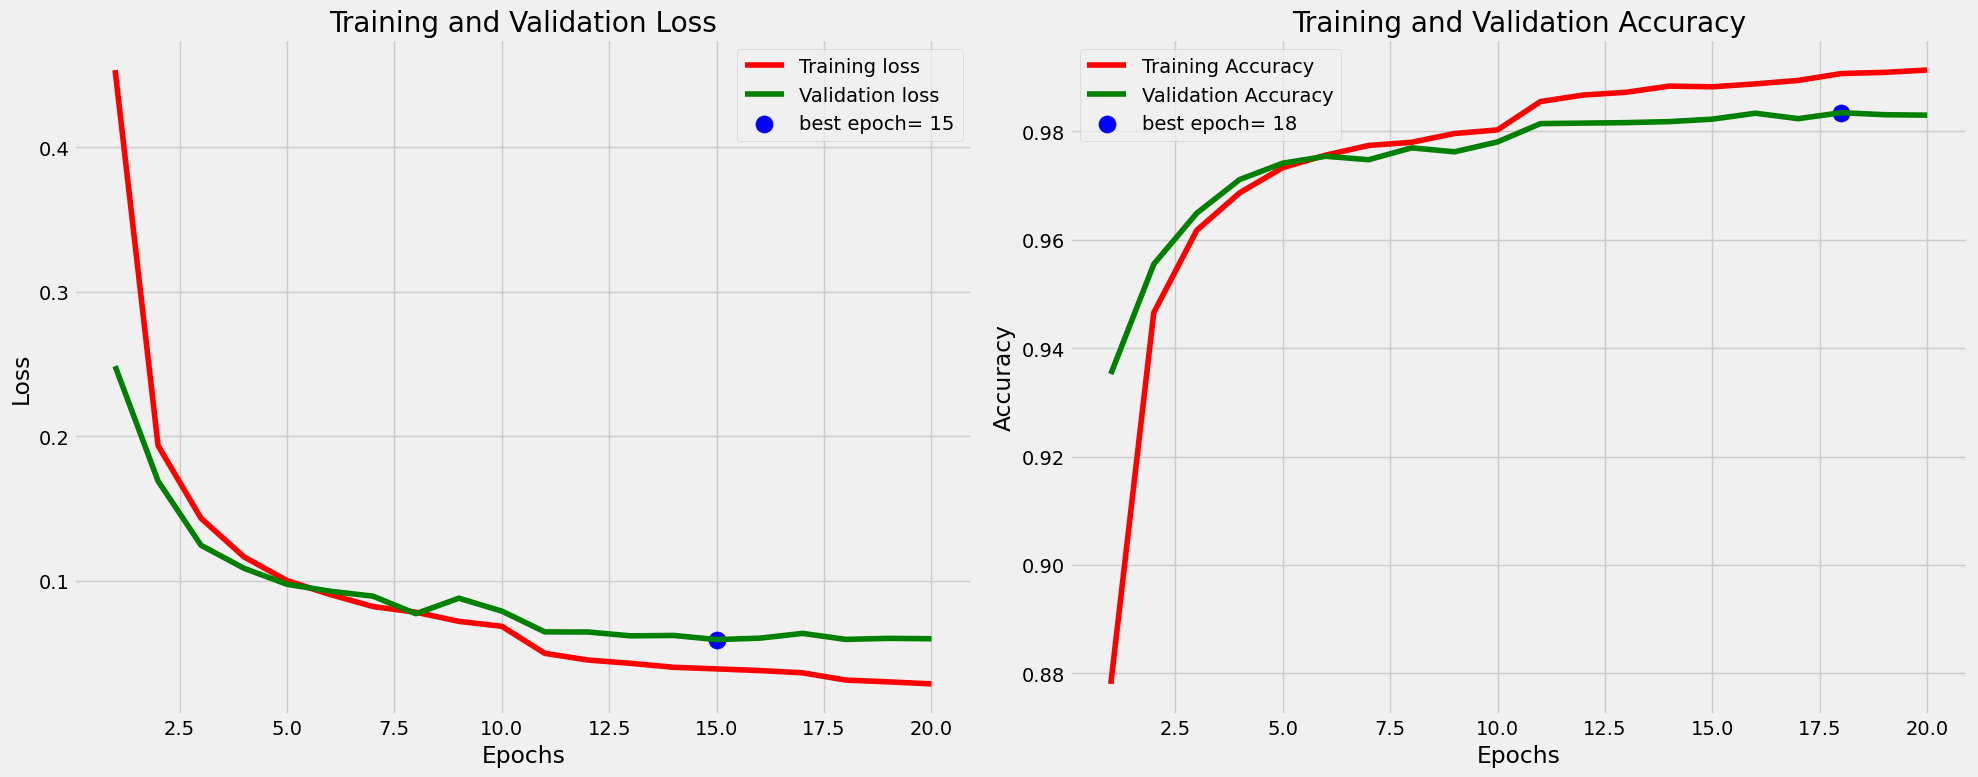

In [23]:
learning_curves_plot(gru_history, start_epoch=0)

In [24]:
y_test_pred_gru = gru_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step


In [25]:
# Evaluate GRU Model on Test Data
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

GRU Test Loss: 0.0570
GRU Test Accuracy: 0.9847


In [26]:
# GRU classification report
print("GRU Classification Report:")
print(classification_report(y_test_new, y_test_pred_gru))

GRU Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9059
         1.0       0.86      0.76      0.80       278
         2.0       0.97      0.96      0.96       724
         3.0       0.85      0.77      0.81        81
         4.0       1.00      0.99      0.99       804

    accuracy                           0.98     10946
   macro avg       0.93      0.89      0.91     10946
weighted avg       0.98      0.98      0.98     10946



In [28]:
class_names = [labels[i] for i in range(len(labels))]

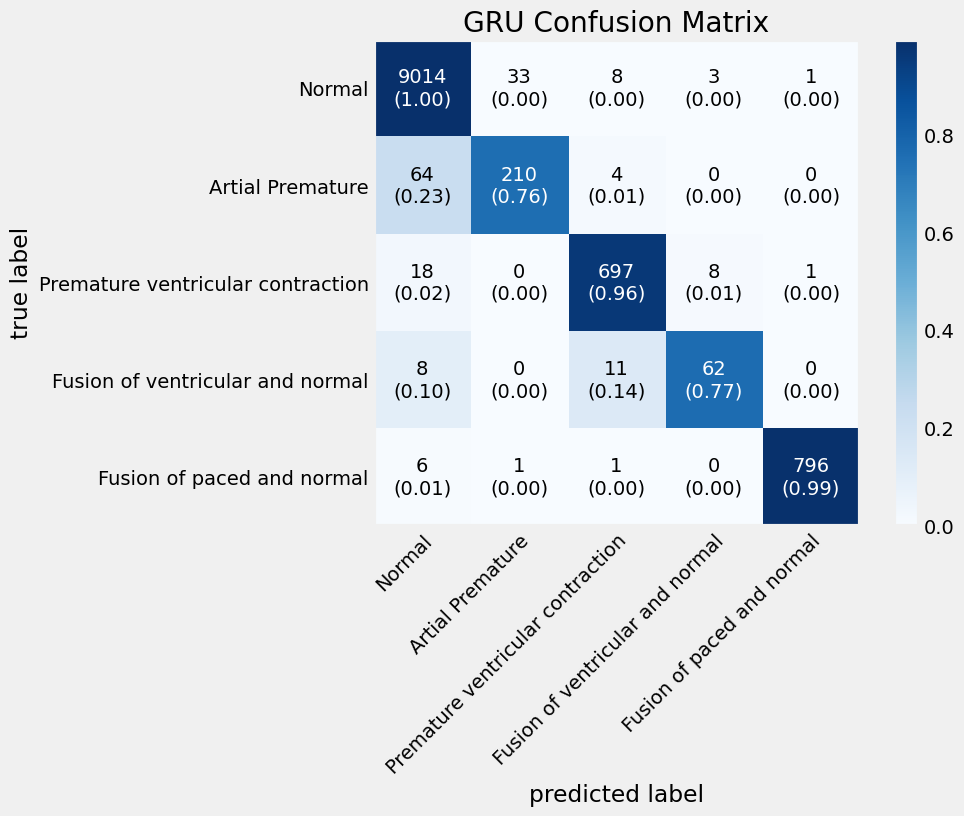

In [29]:
# Confusion matrix for GRU
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

# LSTM

In [30]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    return model

In [31]:
lstm_model = build_lstm_model()

In [32]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [33]:
lstm_history = lstm_model.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 307s 111ms/step - accuracy: 0.8261 - loss: 0.6817 - val_accuracy: 0.8276 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 284s 104ms/step - accuracy: 0.8272 - loss: 0.6326 - val_accuracy: 0.8276 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 3/20
2736/2737 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8278 - loss: 0.6608
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 283s 104ms/step - accuracy: 0.8278 - loss: 0.6607 - val_accuracy: 0.8239 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 292s 107ms/step - accuracy: 0.8426 - loss: 0.5313 - val_accuracy: 0.8669 - val_loss: 0.4512 - learning_rate: 2.0000e-04
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 290s 106ms/step - accuracy: 0.8674 - loss: 0.4456 - val_accuracy: 0.8774 - val_loss: 0.3935 - learning_rate: 2.0000e-04
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 293s

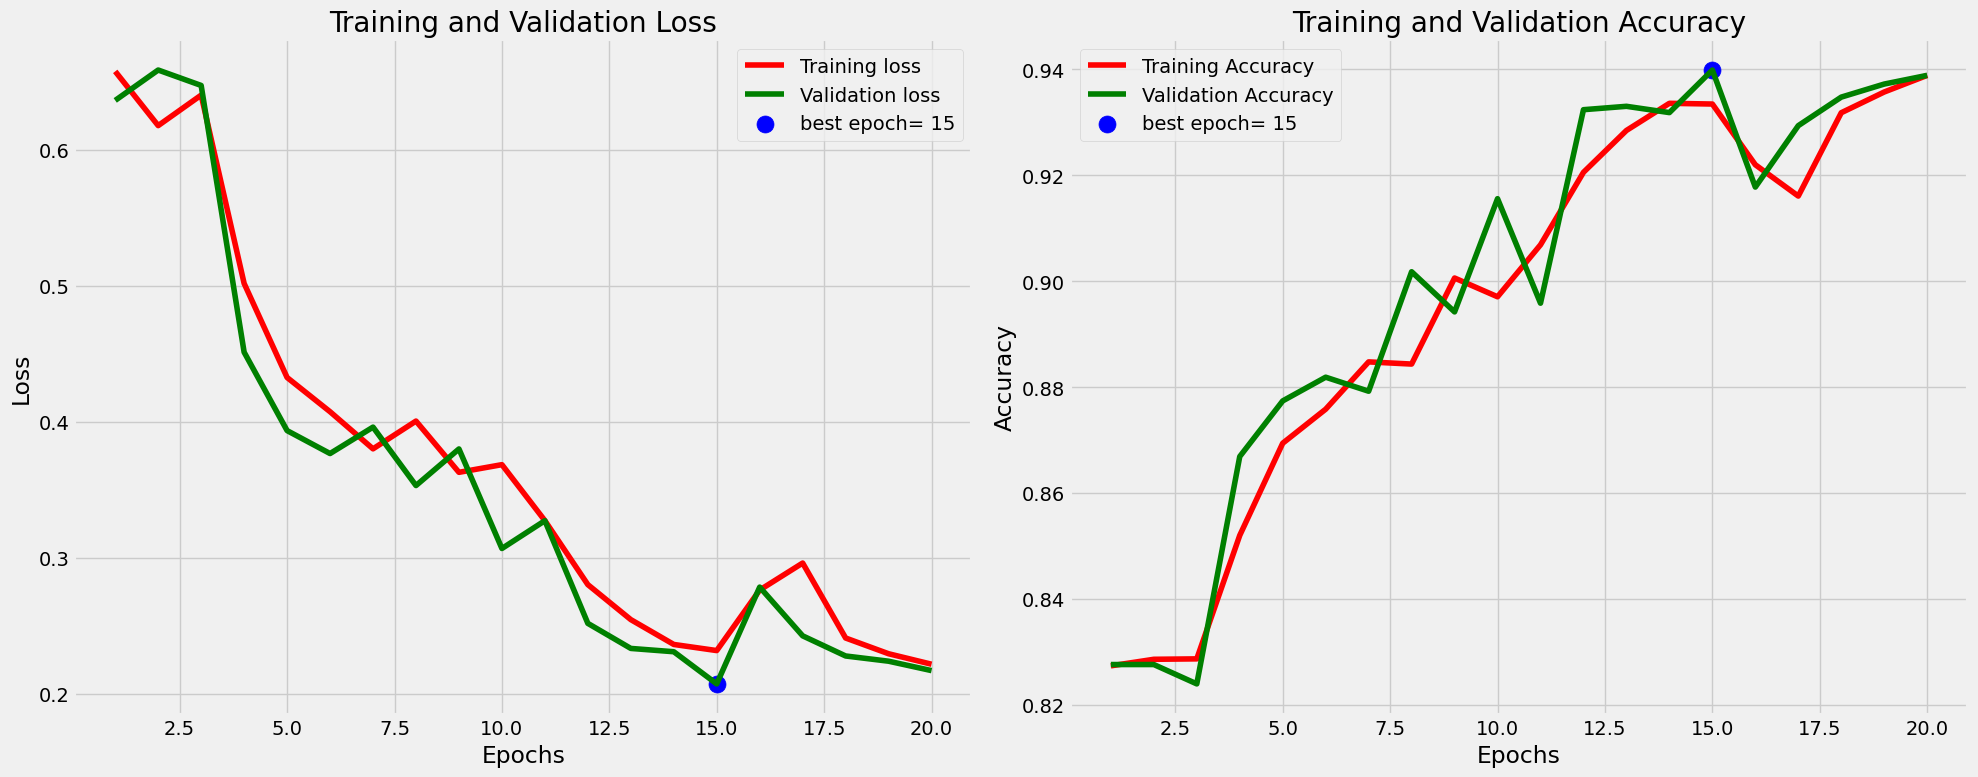

In [34]:
learning_curves_plot(lstm_history, start_epoch=0)

In [35]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step


In [36]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 0.2066
LSTM Test Accuracy: 0.9433


In [37]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))

LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      9059
         1.0       0.80      0.44      0.56       278
         2.0       0.86      0.72      0.78       724
         3.0       0.54      0.40      0.46        81
         4.0       0.95      0.88      0.92       804

    accuracy                           0.94     10946
   macro avg       0.82      0.68      0.74     10946
weighted avg       0.94      0.94      0.94     10946



In [38]:
class_names = [labels[i] for i in range(len(labels))]

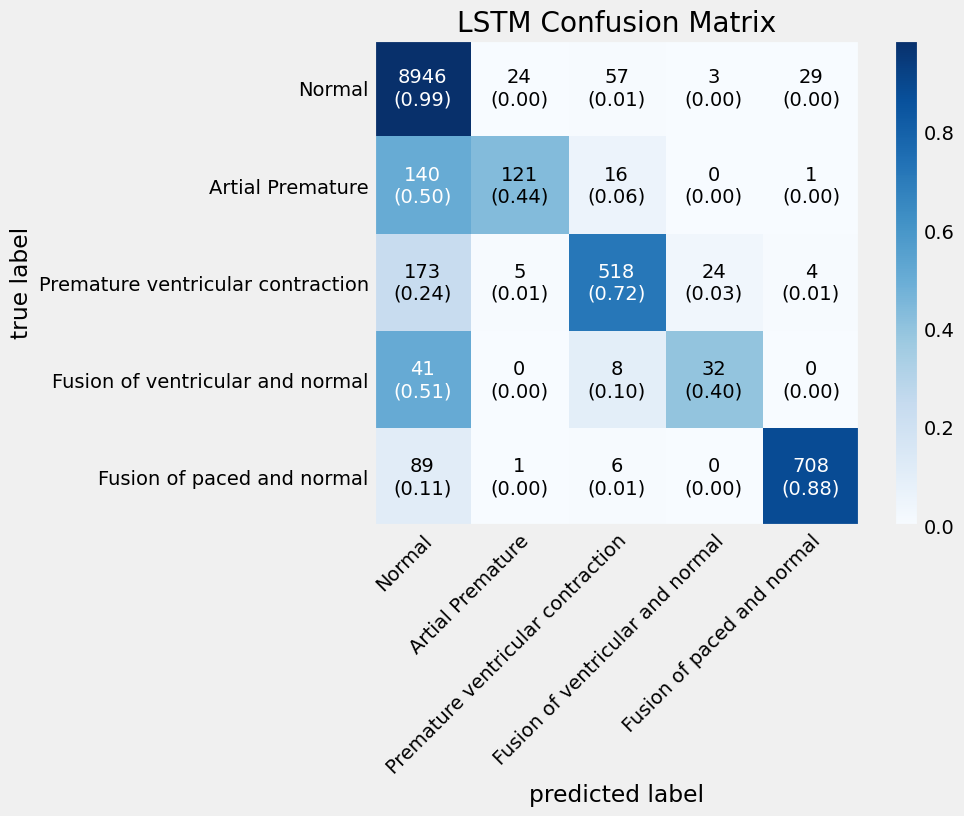

In [39]:
# Confusion matrix for LSTM
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()